## To generate the preProcessed hdf5 files to directly feed to the network

In [2]:
import numpy as np
import os, sys, shutil
import scipy.ndimage as snd
import h5py
import SimpleITK as sitk
import skimage.morphology as morph
from skimage.feature import canny
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

##### All the pre-processing functions

In [28]:
selem = morph.disk(4)
def getWeightMap(label):
    label = np.argmax(label, axis=3)[0]
    edge = np.float32(morph.binary_dilation(canny(np.float32(label)), selem))
    weight_map = np.zeros(label.shape)
    weight_map[np.where(label>0)] = 4
    weight_map = weight_map + 1
    weight_map[np.where(edge==1.0)] = 25
    weight_map[np.where(label == 2.0)] = 15
    return np.uint8(weight_map[None,:,:])

def downSampleImage(image):
    return np.float64(snd.interpolation.zoom(image, 0.5))

def oneHot(targets,n_class = 6):
    axis = targets.ndim
    ret_val = (np.arange(n_class) == np.expand_dims(targets,axis = axis)).astype(int)
    return ret_val

def loadDicomVolume(file_path, itk_image):
    reader = sitk.ImageSeriesReader()
    reader.SetOutputPixelType(sitk.sitkFloat32)
    dicom_names = reader.GetGDCMSeriesFileNames(file_path)
    reader.SetFileNames(dicom_names)
    itk_image = reader.Execute()
    image_vol = sitk.GetArrayFromImage(self.itk_image)
    image_vol = np.transpose(image_vol,(1,2,0))
    return np.float32(image_vol)

def HU_window(in_arr):
    arr1 = in_arr.copy()
    arr2 = in_arr.copy()
    arr3 = in_arr.copy()
    return np.clip(arr1, 0, 100), np.clip(arr2, -100, 200), np.clip(arr3, -100, 400)

def histogram_equalization(arr):
    nbr_bins = 256
    imhist, bins = np.histogram(arr.flatten(), nbr_bins, normed = True)
    cdf = imhist.cumsum()
    cdf = 255 * cdf / cdf[-1]
    original_shape = arr.shape
    arr = np.interp(arr.flatten(), bins[:-1], cdf)
    out_arr = arr.reshape(original_shape)
    return out_arr

def normalize(x):
    x = np.float32(x)
    min_val = np.min(x)
    max_val = np.max(x)
    ret_val = (x - min_val) / (max_val - min_val)
    return ret_val

def downSample(slc1,slc2,slc3):
    return snd.interpolation.zoom(slc1,0.5), snd.interpolation.zoom(slc2,0.5), snd.interpolation.zoom(slc3,0.5)

def makeInput(slc1,slc2,slc3):
    image = np.zeros((1,256,256,3))
    image[0,:,:,0] = slc1
    image[0,:,:,1] = slc2
    image[0,:,:,2] = slc3
    return image

def makeLablel(lbl):
    lbl = oneHot(lbl,3)
    return np.uint8(lbl[None,:,:])

def get_z_minmax(lbl):
    maxes = np.max(lbl,axis =(1,2))
    nonzero_maxes = np.nonzero(maxes)[0]
    mn, mx = nonzero_maxes[0] - 10, nonzero_maxes[-1] + 10
    if mn < 0:
        mn = 0
    if mx >= lbl.shape[0]:
        mx = lbl.shape[0]-1
    return mn, mx

##### Generate all the filepaths of the volumes and corresponding segmenataitons

In [29]:
root = '/windows/Lits2017/DataSet/'
dest = '/windows/Lits2017/DataSet/hdf5/'
mode = 'val'

if not os.path.exists(os.path.join(dest,mode)):
    os.makedirs(os.path.join(dest,mode))

all_fls = os.listdir(os.path.join(root,mode))

vols = []
segs = []

for each in all_fls:
    if 'volume-' in each:
        vols.append(each)
    elif 'segmentation-' in each:
        segs.append(each)

vols.sort()
segs.sort()

In [30]:
len(vols)

26

In [24]:
for volume in tqdm(vols):
    vol_path = os.path.join(root,mode,volume)
    print("working on " + vol_path)
    label_path = os.path.join(root,mode,'segmentation-' + volume.split('-')[-1])
    vol_img = sitk.ReadImage(vol_path)
    label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))
    vol = sitk.GetArrayFromImage(vol_img)
    vol1, vol2, vol3 = HU_window(vol)
    vol1 = histogram_equalization(vol1)
    vol2 = histogram_equalization(vol2)
    vol3 = histogram_equalization(vol3)
    vol1 = normalize(vol1)
    vol2 = normalize(vol2)
    vol3 = normalize(vol3)
    z_min, z_max = get_z_minmax(label)
    for i in range(z_min, z_max):
        slc1 = vol1[i,:,:]
        slc2 = vol2[i,:,:]
        slc3 = vol3[i,:,:]
        slc1,slc2,slc3 = downSample(slc1,slc2,slc3)
        com_slc = makeInput(slc1, slc2, slc3)
        lbl = makeLablel(label[i,:,:])
        weight_map = getWeightMap(lbl)
        hp = h5py.File(os.path.join(dest,mode,volume+'_'+ str(i)+'.hdf5'),'w')
        hp.create_dataset('image', data=com_slc)
        hp.create_dataset('label', data=lbl)
        hp.create_dataset('weight_map', data=weight_map)
        hp.close()

  0%|          | 0/26 [00:00<?, ?it/s]

working on /windows/Lits2017/DataSet/val/volume-101.nii
Bad spacing in volume-101.nii | spacing : (0.705078125, 0.705078125, 0.699999988079071)

  4%|▍         | 1/26 [00:04<01:46,  4.25s/it]


working on /windows/Lits2017/DataSet/val/volume-106.nii
Bad spacing in volume-106.nii | spacing : (0.7289999723434448, 0.7289999723434448, 0.800000011920929)

  8%|▊         | 2/26 [00:08<01:40,  4.19s/it]


working on /windows/Lits2017/DataSet/val/volume-109.nii
Bad spacing in volume-109.nii | spacing : (0.7630000114440918, 0.7630000114440918, 0.800000011920929)

 12%|█▏        | 3/26 [00:12<01:34,  4.12s/it]


working on /windows/Lits2017/DataSet/val/volume-111.nii
Bad spacing in volume-111.nii | spacing : (0.7820000052452087, 0.7820000052452087, 0.800000011920929)

 15%|█▌        | 4/26 [00:15<01:28,  4.01s/it]


working on /windows/Lits2017/DataSet/val/volume-126.nii
Bad spacing in volume-126.nii | spacing : (0.6640625, 0.6640625, 1.5)

 19%|█▉        | 5/26 [00:18<01:14,  3.53s/it]


working on /windows/Lits2017/DataSet/val/volume-18.nii
Bad spacing in volume-18.nii | spacing : (0.921875, 0.921875, 0.800000011920929)

 23%|██▎       | 6/26 [00:22<01:14,  3.75s/it]


working on /windows/Lits2017/DataSet/val/volume-22.nii
Bad spacing in volume-22.nii | spacing : (0.9765620231628418, 0.9765620231628418, 3.2699999809265137)

 31%|███       | 8/26 [00:46<02:39,  8.86s/it]


working on /windows/Lits2017/DataSet/val/volume-32.nii
working on /windows/Lits2017/DataSet/val/volume-33.nii

 35%|███▍      | 9/26 [01:07<03:31, 12.42s/it]


working on /windows/Lits2017/DataSet/val/volume-34.nii

 38%|███▊      | 10/26 [01:39<04:53, 18.36s/it]


working on /windows/Lits2017/DataSet/val/volume-45.nii

 42%|████▏     | 11/26 [01:50<04:03, 16.26s/it]


working on /windows/Lits2017/DataSet/val/volume-54.nii
Bad spacing in volume-54.nii | spacing : (0.828125, 0.828125, 5.0)

 46%|████▌     | 12/26 [01:51<02:43, 11.67s/it]


working on /windows/Lits2017/DataSet/val/volume-58.nii
Bad spacing in volume-58.nii | spacing : (0.6835939884185791, 0.6835939884185791, 2.0)

 50%|█████     | 13/26 [01:53<01:50,  8.53s/it]


working on /windows/Lits2017/DataSet/val/volume-59.nii
Bad spacing in volume-59.nii | spacing : (0.6835939884185791, 0.6835939884185791, 2.0)

 54%|█████▍    | 14/26 [01:57<01:28,  7.33s/it]


working on /windows/Lits2017/DataSet/val/volume-6.nii
Bad spacing in volume-6.nii | spacing : (0.873046875, 0.873046875, 1.0)

 58%|█████▊    | 15/26 [02:00<01:06,  6.07s/it]


working on /windows/Lits2017/DataSet/val/volume-60.nii
Bad spacing in volume-60.nii | spacing : (0.7988280057907104, 0.7988280057907104, 2.0)

 62%|██████▏   | 16/26 [02:04<00:54,  5.48s/it]


working on /windows/Lits2017/DataSet/val/volume-65.nii
Bad spacing in volume-65.nii | spacing : (0.625, 0.625, 0.7989500164985657)

 65%|██████▌   | 17/26 [02:08<00:43,  4.89s/it]


working on /windows/Lits2017/DataSet/val/volume-69.nii
Bad spacing in volume-69.nii | spacing : (0.75390625, 0.75390625, 2.0)

 69%|██████▉   | 18/26 [02:11<00:33,  4.25s/it]


working on /windows/Lits2017/DataSet/val/volume-72.nii
Bad spacing in volume-72.nii | spacing : (0.6777340173721313, 0.6777340173721313, 2.5)

 73%|███████▎  | 19/26 [02:12<00:24,  3.52s/it]


working on /windows/Lits2017/DataSet/val/volume-78.nii
Bad spacing in volume-78.nii | spacing : (0.7851560115814209, 0.7851560115814209, 2.5)

 77%|███████▋  | 20/26 [02:15<00:18,  3.11s/it]


working on /windows/Lits2017/DataSet/val/volume-8.nii
Bad spacing in volume-8.nii | spacing : (0.84765625, 0.84765625, 1.0)

 81%|████████  | 21/26 [02:19<00:17,  3.58s/it]


working on /windows/Lits2017/DataSet/val/volume-88.nii
Bad spacing in volume-88.nii | spacing : (0.7559999823570251, 0.7559999823570251, 0.800000011920929)

 85%|████████▍ | 22/26 [02:26<00:17,  4.40s/it]


working on /windows/Lits2017/DataSet/val/volume-89.nii
Bad spacing in volume-89.nii | spacing : (0.6370000243186951, 0.6370000243186951, 0.800000011920929)

 88%|████████▊ | 23/26 [02:30<00:12,  4.32s/it]


working on /windows/Lits2017/DataSet/val/volume-92.nii
Bad spacing in volume-92.nii | spacing : (0.6710000038146973, 0.6710000038146973, 0.800000011920929)

 92%|█████████▏| 24/26 [02:34<00:08,  4.34s/it]


working on /windows/Lits2017/DataSet/val/volume-94.nii
Bad spacing in volume-94.nii | spacing : (0.837890625, 0.837890625, 0.699999988079071)

 96%|█████████▌| 25/26 [02:38<00:04,  4.21s/it]


working on /windows/Lits2017/DataSet/val/volume-97.nii
Bad spacing in volume-97.nii | spacing : (0.72265625, 0.72265625, 0.699999988079071)

100%|██████████| 26/26 [02:39<00:00,  3.13s/it]

In [ ]:
img = sitk.ReadImage('/windows/Lits2017/DataSet/train/volume-0.nii')

In [ ]:
img.GetSpacing() == (0.703125, 0.703125, 5.0)

In [17]:
os.makedirs('/windows/Lits2017/DataSet/hdf5/train1/')

In [25]:
for each in tqdm(os.listdir(os.path.join(dest,'train1'))):
    shutil.move(os.path.join(dest,'train1',each),os.path.join(dest,'train'))

  0%|          | 0/18938 [00:00<?, ?it/s]


IOError: [Errno 28] No space left on device: '/windows/Lits2017/DataSet/hdf5/train/volume-21.nii_0.hdf5'

In [5]:
lbl = sitk.GetArrayFromImage(sitk.ReadImage('/windows/Lits2017/DataSet/train/segmentation-0.nii'))

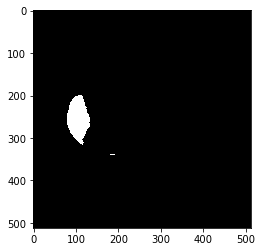

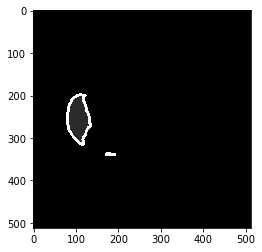

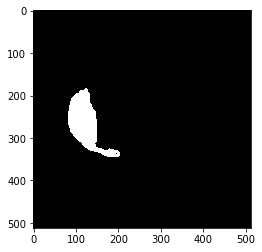

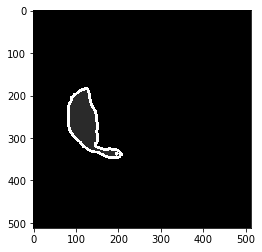

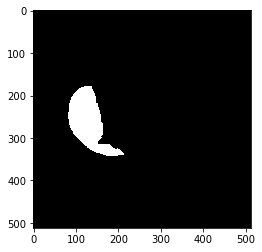

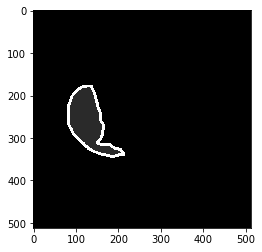

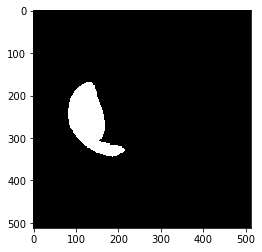

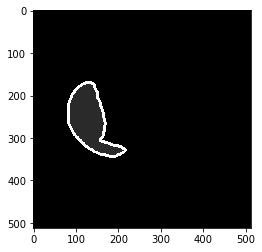

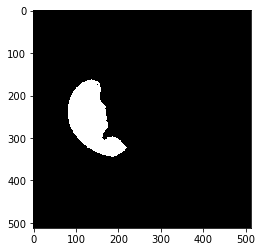

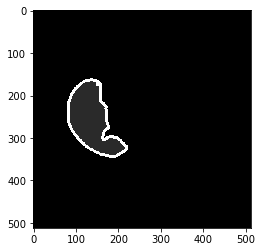

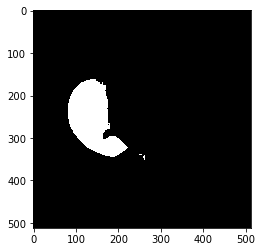

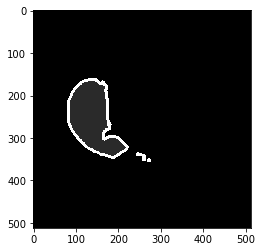

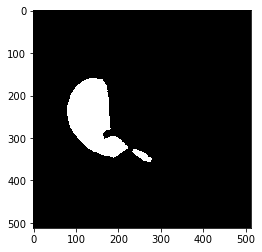

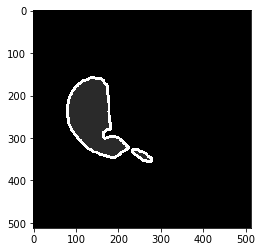

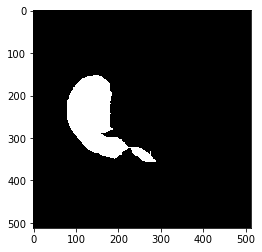

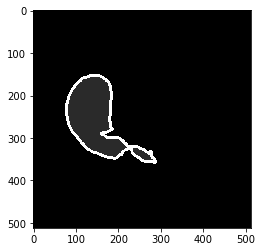

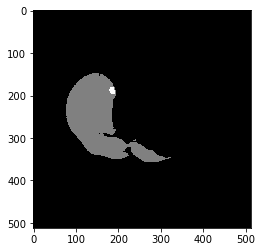

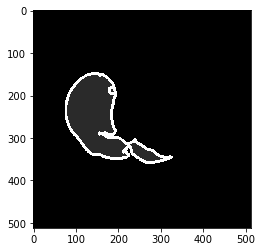

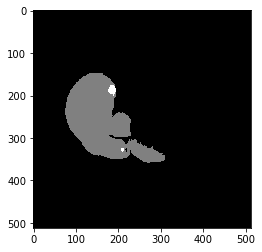

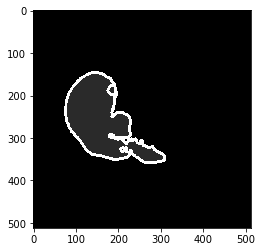

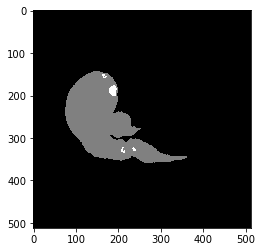

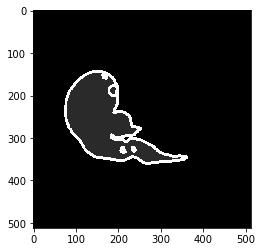

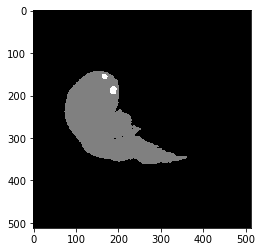

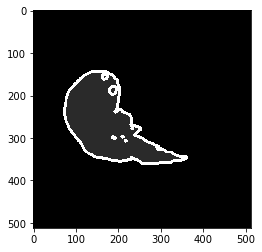

In [19]:
# sl_n = 50
for sl_n in range(48,60):
    lbl1 = makeLablel(lbl[sl_n,:,:])
    w_map = getWeightMap(lbl1)
    plt.imshow(lbl[sl_n,:,:],cmap='gray')
    plt.show()
    plt.imshow(w_map[0,:,:],cmap='gray')
    plt.show()

In [13]:
lbl1.shape

(1, 512, 512, 3)

In [24]:
maxes = np.max(lbl,axis =(1,2))
nonzero_maxes = np.nonzero(maxes)[0]

In [26]:
nonzero_maxes[-1]

73